# Modeling


In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#Load data and transform the price variable to log_price
db_all = pd.read_csv('data/analysis_ready.csv.gz')
db_all['l_price'] = np.log(db_all['price_cleansed'])

In [3]:
#New dataframe with selected variables only and missing values removed. 
xs = ['l_price', 'bedrooms', 'bathrooms', 'beds', 'room_type']
db = db_all[xs].dropna()
db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53509 entries, 0 to 53903
Data columns (total 5 columns):
l_price      53509 non-null float64
bedrooms     53509 non-null float64
bathrooms    53509 non-null float64
beds         53509 non-null float64
room_type    53509 non-null object
dtypes: float64(4), object(1)
memory usage: 2.4+ MB


## Baseline model

$$
\log(P) = \alpha + X \beta + \epsilon
$$

$X$:

- Bathrooms
- Bedrooms
- Beds
- Room type

The baseline model is specified as a Loglinear model, which means that the dependent variable (Price) has been logged while the explanatory variables have been left as linear covariates. The Y-variable is often logged in this way to account Heteroscedasticity - i.e. 'unequal spread' of the X-variables at higher levels of the Y variable. In this context, heteroscedasticity means that at higher prices for AirBnB properties, there is much higher variation in the number of bedrooms, bathrooms, beds and room types available for visitors compared to lower-priced accomodation. This unequal spread can be addressed to an extent by taking the log of the dependent variable.

The interpretation of the coefficients then changes somewhat: we say that a unit change in the number of bedrooms, bathrooms and beds leads to a percentage change (rather than a £ change) in the price of the property. 

In [4]:
#Model 1
m1 = sm.ols('l_price ~ bedrooms + bathrooms + beds', db).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     8823.
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:06:20   Log-Likelihood:                -46041.
No. Observations:               53509   AIC:                         9.209e+04
Df Residuals:                   53505   BIC:                         9.213e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6139      0.006    573.011      0.000       3.602       3.626
bedrooms       0.2914      0.005     63.625      0.000       0.282       0.300
bathrooms      0.0255      0.005      4.699      0.000       0.015       0.036
beds           0.1466      0.003     47.363      0.000       0.141       0.153
==============================================================================
Omnibus:                     1229.914   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2834.743
Skew:                           0.040   Prob(JB):                         0.00
Kurtosis:                       4.125   Cond. No.                         9.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To note:

- Decent $R^2$ (although that's not holy truth)
- Every variable significant and related as expected
- Interpret coefficients

The $R^2$ statistic is an indicator of the goodness-of-fit of the model; its range is between Zero and One. Values closer to One imply that a larger proportion of the variation in the data is explained by the model. It depends on sample size and the number of explanatory variables in the model. The bigger the sample size the better, but adding more and more variables, even if they are irrelevant to the dependent variable (e.g. telephone number), can lead to an artifical inflation of the $R^2$ figure so one has to be careful when making claims about goodness-of-fit based on the $R^2$ statistic taken by itself. Alternative measures are the AIC (Akaike Information Criteria) and BIC (Bayesian Information Criteria), both given in the tables above. However, for this exercise, the $R^2$ measure is sufficient.   

In [5]:
#Scaling and Centring the data
cols = ['bedrooms', 'bathrooms', 'beds']
scX = pd.DataFrame(scale(db[cols]),
                   index=db.index,
                   columns=cols)

#Re-estimate as Model 2
m2 = sm.ols('l_price ~ bedrooms + bathrooms + beds', 
            data=scX.join(db['l_price']))\
       .fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     8823.
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:06:20   Log-Likelihood:                -46041.
No. Observations:               53509   AIC:                         9.209e+04
Df Residuals:                   53505   BIC:                         9.213e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2917      0.002   1735.312      0.000       4.287       4.297
bedrooms       0.2458      0.004     63.625      0.000       0.238       0.253
bathrooms      0.0140      0.003      4.699      0.000       0.008       0.020
beds           0.1762      0.004     47.363      0.000       0.169       0.184
==============================================================================
Omnibus:                     1229.914   Durbin-Watson:                   1.556
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2834.743
Skew:                           0.040   Prob(JB):                         0.00
Kurtosis:                       4.125   Cond. No.                         2.92
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To note:

How does interpretation of the coefficients change?
* Meaning of intecept when $X$ is demeanded
* Units in which $\beta$ are interpreted

## Predictive checking

Is the model picking up the overall "shape of data"?

- Important to know how much we should trust our inferences
- Crucial if we want to use the model to predict!

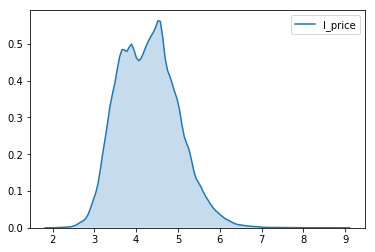

In [6]:
#Inspect shape of log-price distribution: does it look bell-shaped i.e. well-behaved?
sns.kdeplot(db['l_price'], shade=True)

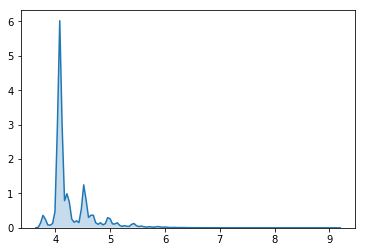

In [7]:
#Inspect shape of Model 1
sns.kdeplot(m1.fittedvalues, shade=True)

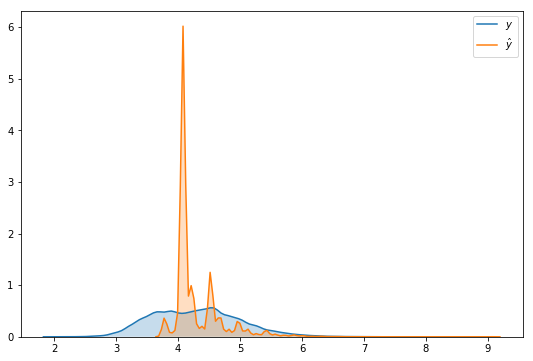

In [8]:
#Overlay plots for comparison. 
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$')
plt.show()

To note:

- Not a terrible start
- How could we improve it?

In [9]:
#Model 3 estimated to examine effect of 'room_type' on model fit.  
m3 = sm.ols('l_price ~ bedrooms + bathrooms + beds + room_type', db).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                l_price   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                 1.630e+04
Date:                Fri, 23 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:06:21   Log-Likelihood:                -32031.
No. Observations:               53509   AIC:                         6.407e+04
Df Residuals:                   53503   BIC:                         6.413e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.2139      0.006    724.314      0.000       4.203       4.225
room_type[T.Private room]    -0.7901      0.004   -184.073      0.000      -0.799      -0.782
room_type[T.Shared room]     -1.3001      0.017    -76.812      0.000      -1.333      -1.267
bedrooms                      0.1757      0.004     49.030      0.000       0.169       0.183
bathrooms                     0.1211      0.004     28.774      0.000       0.113       0.129
beds                          0.0491      0.002     19.925      0.000       0.044       0.054
==============================================================================
Omnibus:                     7192.898   Durbin-Watson:                   1.671
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28913.080
Skew:                           0.628   Prob(JB):                         0.00
Kurtosis:                       6.375   Cond. No.                         26.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

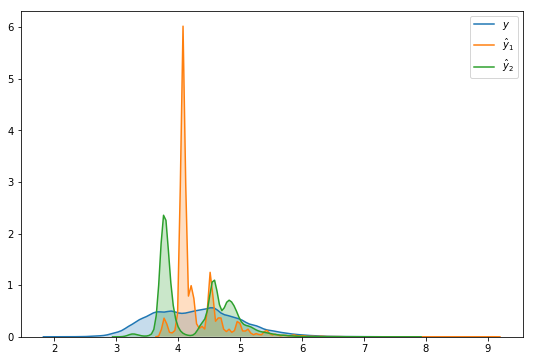

In [10]:
f, ax = plt.subplots(1, figsize=(9, 6))
sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}_1$')
sns.kdeplot(m3.fittedvalues, shade=True, ax=ax, label='$\hat{y}_2$')
plt.show()

To note:

- This is better!
- But these are only point predictions. Sometimes that's good enough.
- Usually however, we want a model to capture the underlying process instead of the particular realisation observed (ie. dataset).
- Then we need to think about the uncertainty embedded in the model we are estimating

## Inferential Vs Predictive uncertainty

[See more in Chapter 7.2 of [Gelman & Hill 2006](http://www.stat.columbia.edu/~gelman/arm/)]

- Two types of uncertainty in our model
    + Predictive ($\epsilon$)
    + Inferential ($\beta$)
- Both affect the final predictions we make

![](../figs/d3s2_example.png)

In [11]:
#Locate a specific property and predict its price based on the parameters (betas) of our model. 
#Does this match the actual price? 
#If so, we might have found a good model, and made a good choice as to the explanatory variables we have selected.

db_all.loc[db_all['id']==7849135, :].T

,38951
review_scores_rating,96
review_scores_accuracy,10
review_scores_cleanliness,10
review_scores_checkin,10
review_scores_communication,10
review_scores_location,10
review_scores_value,9
id,7849135
last_scraped,2017-03-04
last_review,2017-02-17


In [12]:
hid = 38951

In [13]:
db.loc[hid, :]

l_price              4.23411
bedrooms                   1
bathrooms                  2
beds                       3
room_type    Entire home/apt
Name: 38951, dtype: object

$$
\hat{\log(P_i)} = \alpha + \sum_k \beta_k * X_k
$$

In [14]:
m1.params['Intercept'] + db.loc[hid, cols].dot(m1.params[cols])

4.396095126749933

To note:

- What does `dot` do?

In [15]:
m1.fittedvalues[hid]

4.396095126749933

In [16]:
# Point predictive simulation. Here we want to check how: 
#different values of our Beta parameters and error term might change our predicted price, and 
#what the distribution of the change is. 
#This then gives us a useful interval estimate of plausible minimum and maximum price bounds for our house of interest, defined by the Confidence Intervals. 

In [17]:
%%time
# Parameters
## Number of simulations
r = 2000
# Pull out characteristics for house of interest
x_i = db.loc[hid, cols]
# Specify model engine
model = m1

# Place-holder
sims = np.zeros(r)
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal(0, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
    # Store estimate
    sims[i] = y_hr

CPU times: user 476 ms, sys: 0 ns, total: 476 ms
Wall time: 474 ms


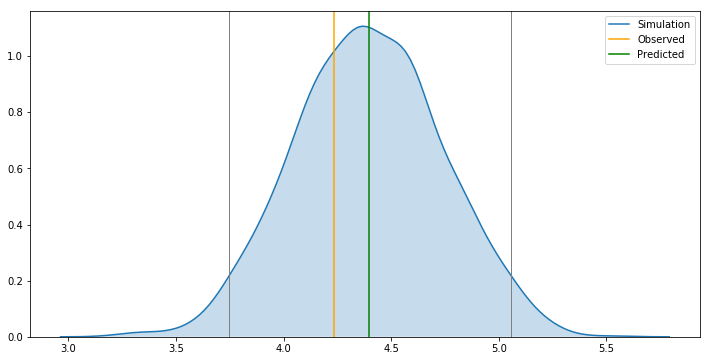

In [18]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(sims, shade=True, ax=ax, label='Simulation')
ax.axvline(db.loc[hid, 'l_price'], c='orange', label='Observed')
ax.axvline(model.fittedvalues[hid], c='green', label='Predicted')

lo, up = pd.Series(sims).sort_values().iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
ax.axvline(lo, c='grey', linewidth=1)
ax.axvline(up, c='grey', linewidth=1)

plt.legend()
plt.show()

To note:

- Intuition of the simulation
- The `for` loop, deconstructed
- The graph, bit by bit
- If we did this for every observation, we'd expect 95% to be within the 95% bands

**Exercise**

Explore with the code above and try to generate similar plots for:

- Different houses across locations and characteristics
- Different model

Now, we could do this for *all* the observations and get a sense of the overall distribution to be expected

In [19]:
%%time
# Parameters
## Number of observations & simulations
n = db.shape[0]
r = 200
# Specify model engine
model = m1

# Place-holder (N, r)
sims = np.zeros((n, r))
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal([0]*n, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(db[cols], rbs[1:]) + re
    # Store estimate
    sims[:, i] = y_hr

CPU times: user 5.07 s, sys: 12.2 s, total: 17.2 s
Wall time: 2.42 s


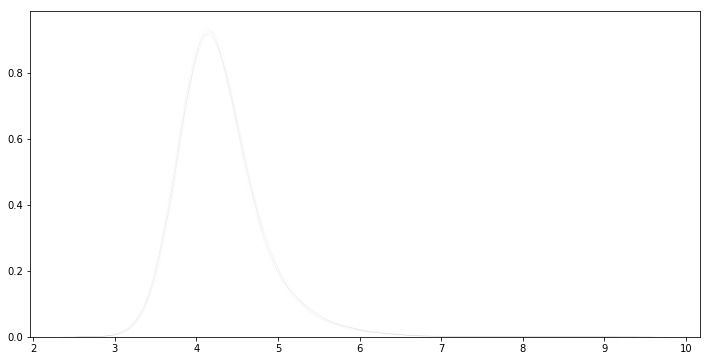

In [20]:
f, ax = plt.subplots(1, figsize=(12, 6))

for i in range(10):
    sns.kdeplot(sims[:, i], ax=ax, linewidth=0.1, alpha=0.1, color='k')
    
plt.show()

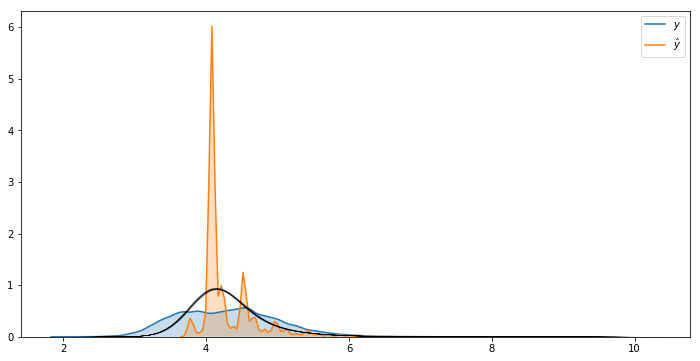

In [21]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(db['l_price'], shade=True, ax=ax, label='$y$')
sns.kdeplot(m1.fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

for i in range(r):
    sns.kdeplot(sims[:, i], ax=ax, linewidth=0.1, alpha=0.1, color='k')
    
plt.show()

To note:

- Black line contains `r` thin lines that collectively capture the uncertainty behind the model

### New data

Imagine we are trying to figure out how much should we charge for a property we want to put on AirBnb.

For example, let's assume our property is:

In [22]:
new = pd.Series({'bedrooms': 4,
                 'bathrooms': 1,
                 'beds': 8})

In [23]:
%%time
# Parameters
## Number of simulations
r = 2000
# Pull out characteristics for house of interest
x_i = new
# Specify model engine
model = m1

# Place-holder
sims = np.zeros(r)
# Loop over number of replications
for i in range(r):
    # Get a random draw of betas
    rbs = np.random.normal(model.params, model.bse)
    # Get a random draw of epsilon
    re = np.random.normal(0, model.scale)
    # Obtain point estimate
    y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
    # Store estimate
    sims[i] = y_hr

CPU times: user 452 ms, sys: 4 ms, total: 456 ms
Wall time: 455 ms


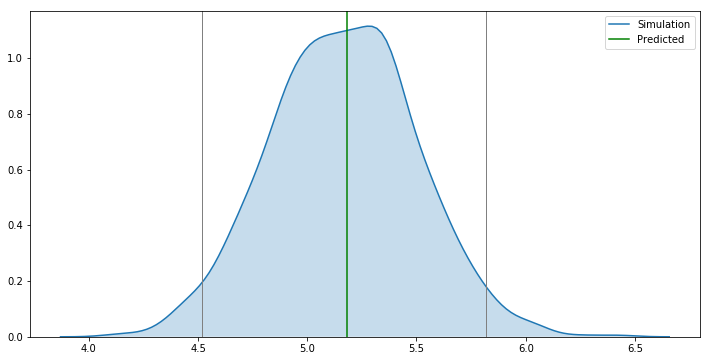

In [24]:
f, ax = plt.subplots(1, figsize=(12, 6))

sns.kdeplot(sims, shade=True, ax=ax, label='Simulation')
ax.axvline(model.params.iloc[0] + np.dot(new, model.params.iloc[1:]), \
           c='green', label='Predicted')

lo, up = pd.Series(sims).sort_values().iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
ax.axvline(lo, c='grey', linewidth=1)
ax.axvline(up, c='grey', linewidth=1)

plt.legend()
plt.show()

**[Pro]**

In [25]:
def predictor(bedrooms, bathrooms, beds):
    new = pd.Series({'bedrooms': bedrooms,
                     'bathrooms': bathrooms,
                     'beds': beds})
    r = 1000
    x_i = new
    model = m1
    #
    sims = np.zeros(r)
    for i in range(r):
        rbs = np.random.normal(model.params, model.bse)
        re = np.random.normal(0, model.scale)
        y_hr = rbs[0] + np.dot(x_i, rbs[1:]) + re
        sims[i] = y_hr
    f, ax = plt.subplots(1, figsize=(12, 6))
    ax.hist(sims, label='Simulation', alpha=0.25, bins=30)
    ax.axvline(model.params.iloc[0] + np.dot(new, model.params.iloc[1:]), \
               c='green', label='Predicted')
    lo, up = pd.Series(sims).sort_values().iloc[[int(np.round(0.025 * r)), int(np.round(0.975 * r))]]
    ax.axvline(lo, c='grey', linewidth=1, label='95% CI')
    ax.axvline(up, c='grey', linewidth=1)
    ax.set_xlim((0, 10))
    plt.legend()
    return plt.show()

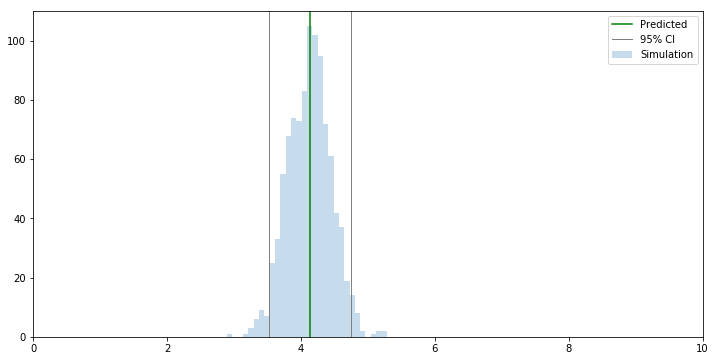

In [26]:
predictor(3, 1, 1)

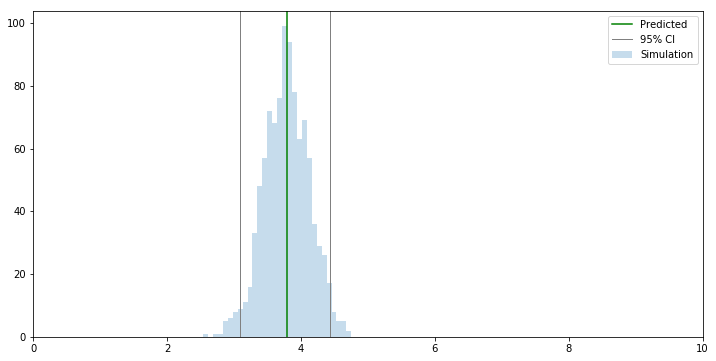

In [27]:
# You might have to run this to make interactives work
# jupyter labextension install @jupyter-widgets/jupyterlab-manager
# From https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-the-jupyterlab-extension
# Then restart Jupyter Lab
from ipywidgets import interact, IntSlider

interact(predictor, bedrooms=IntSlider(min=1, max=10), \
                    bathrooms=IntSlider(min=0, max=10), \
                    beds=IntSlider(min=1, max=20));

## Model performance

To note:

- Switch from inference to prediction
- Overall idea of summarising model performance
- $R^2$
- Error-based measures

In [28]:
# R^2
r2 = pd.Series({'Baseline': metrics.r2_score(db['l_price'],
                                              m1.fittedvalues),
                'Augmented': metrics.r2_score(db['l_price'],
                                              m3.fittedvalues)})
r2

Augmented    0.603708
Baseline     0.330976
dtype: float64

In [29]:
# MSE - Mean Squared Error
mse = pd.Series({'Baseline': metrics.mean_squared_error(db['l_price'],
                                                        m1.fittedvalues),
                 'Augmented': metrics.mean_squared_error(db['l_price'],
                                                         m3.fittedvalues)})
mse

Augmented    0.19385
Baseline     0.32726
dtype: float64

In [30]:
# MAE - Mean Absolute Error
mae = pd.Series({'Baseline': metrics.mean_absolute_error(db['l_price'],
                                                         m1.fittedvalues),
                 'Augmented': metrics.mean_absolute_error(db['l_price'],
                                                          m3.fittedvalues)})
mae

Augmented    0.335668
Baseline     0.457220
dtype: float64

In [31]:
# Display All
perf = pd.DataFrame({'MAE': mae,
                     'MSE': mse,
                     'R^2': r2})
perf

,MAE,MSE,R^2
Augmented,0.335668,0.19385,0.603708
Baseline,0.457220,0.32726,0.330976


## Overfitting & cross-validation

* *What*, *Why*, *When* overfitting
* Little data/lots of parameters --> *Mo* problems!
* What is cross-validation

In [32]:
# Split dataset into two subsets: a Training and Test dataframe. 
x_train, x_test, y_train, y_test = model_selection.train_test_split(db[cols], 
                                                                    db['l_price'],
                                                                    test_size=0.8)

In [33]:
# Train a model
f = 'l_price ~ bedrooms + bathrooms + beds'
m1_tr = sm.ols(f, x_train.assign(l_price=y_train)).fit()

In [34]:
#Compare baseline model (Model 1) with the trained model outputs
pd.DataFrame({'Full Dataset': m1.params,
              'Train Set': m1_tr.params})

,Full Dataset,Train Set
Intercept,3.613890,3.595826
bedrooms,0.291420,0.275760
bathrooms,0.025511,0.041930
beds,0.146588,0.159557


In [35]:
#Extract the R-squared statistics of the two models and compare. 
pd.Series({'Full Dataset': m1.rsquared,
              'Train Set': m1_tr.rsquared})

Full Dataset    0.330976
Train Set       0.340606
dtype: float64

In [36]:
# Now Test on the Test Data
test_pred = m1_tr.params['Intercept'] + \
            x_test.dot(m1_tr.params.drop('Intercept'))
pd.Series({'0-Full Dataset': m1.rsquared,
           '1-Train Set': m1_tr.rsquared,
           '2-Test Set': metrics.r2_score(y_test,
                                        test_pred)})

0-Full Dataset    0.330976
1-Train Set       0.340606
2-Test Set        0.328036
dtype: float64

To note:

* Use of `assign`
* $R^2$ increases with smaller train set, but decreases with testing (not much, which is good! why? Already regularised)

In [37]:
rids = np.arange(db.shape[0])
np.random.shuffle(rids)
r2s = model_selection.cross_val_score(LinearRegression(),
                                      db.iloc[rids, :][cols],
                                      db.iloc[rids, :]['l_price'],
                                      cv=5,
                                      scoring='r2')
print(r2s)
r2s.mean()

[0.34153919 0.32329916 0.32830449 0.32986118 0.32929761]


0.3304603277401932

Just for the fun of it, let's replicate without reshufling IDs:

In [38]:
r2s = model_selection.cross_val_score(LinearRegression(),
                                      db[cols],
                                      db['l_price'],
                                      cv=5,
                                      scoring='r2')
print(r2s)
r2s.mean()

[ 0.16449518  0.34920339 -0.10119646  0.27579852  0.2976514 ]


0.19719040585934616

To note:

* What's happened?
* The i.i.d. assumption
* Structure in the data that is not incorporated
* How is CV affected?

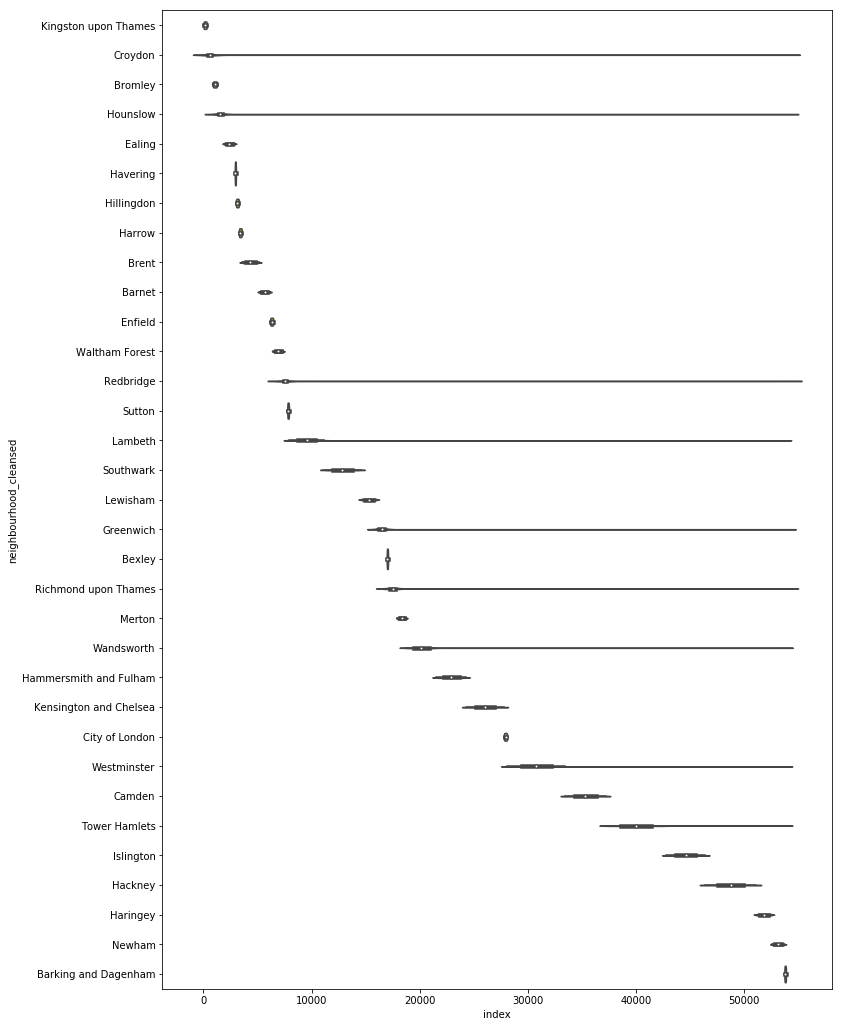

In [39]:
f, ax = plt.subplots(1, figsize=(12, 18))
sns.violinplot(x='index', 
               y='neighbourhood_cleansed', 
               data=db_all.reset_index(),
               ax=ax);

To note:

* Spatial heterogeneity
* More generally, group membership

## More advanced predictive methods: the Random Forest

In [40]:
m4 = RandomForestRegressor().fit(db[cols], db['l_price'])\
                            .predict(db[cols])

To note:

* First `fit`, then `predict` using the same features
* No `params` here because it's a much more flexible functional form

In [41]:
rf = pd.Series({'R^2': metrics.r2_score(db['l_price'], m4), 
                'MSE': metrics.mean_squared_error(db['l_price'], m4),
                'MAE': metrics.mean_absolute_error(db['l_price'], m4)})
pd.concat([perf, 
           pd.DataFrame({'RF': rf}).T])

,MAE,MSE,R^2
Augmented,0.335668,0.193850,0.603708
Baseline,0.457220,0.327260,0.330976
RF,0.396705,0.255943,0.476769


To note:

* Use of `concat`
* Performance comparison

But...

In [42]:
m4_cv = RandomForestRegressor().fit(x_train, y_train)\
                               .predict(x_test)

In [43]:
rf_cv = pd.Series({'R^2': metrics.r2_score(y_test, m4_cv), 
                'MSE': metrics.mean_squared_error(y_test, m4_cv),
                'MAE': metrics.mean_absolute_error(y_test, m4_cv)})
pd.concat([perf, 
           pd.DataFrame({'RF': rf}).T,
           pd.DataFrame({'RF-CV': rf_cv}).T])

,MAE,MSE,R^2
Augmented,0.335668,0.193850,0.603708
Baseline,0.457220,0.327260,0.330976
RF,0.396705,0.255943,0.476769
RF-CV,0.402720,0.266619,0.455753


To note:

* `m4_cv` fits on train, predicts on test
* Comparison RF Vs RF-CV
